In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

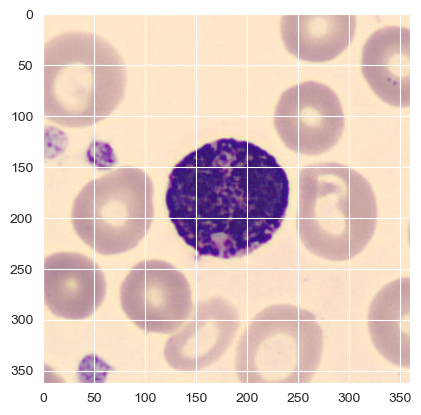

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


In [63]:
# Einlesen eines Bildes
img = mpimg.imread('images/archive/bloodcells_dataset/basophil/BA_47.jpg')
imgplot = plt.imshow(img)
plt.show()

# Daten einlesen
image_size = (224, 224)
batch_size = 32
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    "images/archive/bloodcells_dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    "images/archive/bloodcells_dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

In [64]:
# Daten vorbereiten
train_ds = X_train.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = X_test.prefetch(buffer_size=tf.data.AUTOTUNE)

# Die Gewichte des VGG16 freezen
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False

# Transfer Learning Model aufbauen
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(keras.layers.experimental.preprocessing.RandomRotation(0.1))
model.add(keras.layers.experimental.preprocessing.Rescaling(1.0 / 255) )
model.add(vgg16)

# Eigener Decision Bereich
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))  # Dropout für Regularisierung
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Modell kompilieren
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Zusammenfassung des Modells anzeigen
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_12 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_36 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                     

In [65]:
# Modell trainieren
history1 = model.fit(train_ds, epochs=1, batch_size=50, validation_data=val_ds)
history2 = model.fit(train_ds, epochs=1, batch_size=50, validation_data=val_ds)

  1/428 [..............................] - ETA: 1:42:01 - loss: 2.0654 - accuracy: 0.2188

KeyboardInterrupt: 

In [ ]:
# Historien kombinieren
combined_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
}

# Kombinierte Historie plotten
x = range(0, len(combined_history['accuracy']))
plt.figure(figsize=(12, 7))
sns.lineplot(x=x, y=combined_history['accuracy'], label='Genauigkeit')
sns.lineplot(x=x, y=combined_history['loss'], label='Verlust')
sns.lineplot(x=x, y=combined_history['val_loss'], label='Validierungsverlust')
sns.lineplot(x=x, y=combined_history['val_accuracy'], label='Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit / Verlust')
plt.title('CNN Leistungshistorie')
plt.ylim(0, 1)
plt.show()

# Evaluation auf dem Validierungsdatensatz
model.evaluate(val_ds)

In [ ]:
# Modell speichern
model.save("transfer_learning.h5")


In [ ]:
# Jetzt Produktion
from keras.models import load_model
model_loaded = load_model('transfer_learning.h5')

# Beispielvorhersagen
img = keras.preprocessing.image.load_img("images/archive/bloodcells_dataset/erythroblast/ERB_5435.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predict = model_loaded.predict(img_array)
print(predict)